In [1]:
import ast
import os
import random
import re

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from __future__ import annotations
from codealltag_data_processor_v2025 import CodealltagDataProcessor
from concurrent.futures import ThreadPoolExecutor, as_completed
from pandas import DataFrame
from pandas.core.series import Series
from tqdm import tqdm
from typing import Any, Dict, Generator, List, Tuple

In [2]:
cdp_2022 = CodealltagDataProcessor(data_version='20220513', config_path=['codealltag_data_processor.yml'])

In [3]:
sample_size = 10_000
k = 3

In [4]:
predicted_text_df_name = f'PredictedText_DF_{cdp_2022.get_data_version()}_{sample_size // 1000}K_k{k}.csv'
predicted_text_df = pd.read_csv(predicted_text_df_name, index_col=0)

In [5]:
def prepare_performance_metrics_dict(predicted_text_df: DataFrame, 
                                     idx: int, 
                                     cdp: CodealltagDataProcessor) -> Dict[str, Tuple]:
    
    def update_label_dict(tp_fp_fn_dict: Dict[str, Dict[str, int]], 
                          label: str, 
                          metric: str, 
                          value: int):
        
        label_dict = tp_fp_fn_dict.get(label, dict())
        label_metric_value = label_dict.get(metric, 0)
        label_dict[metric] = label_metric_value + value
        tp_fp_fn_dict[label] = label_dict
        return tp_fp_fn_dict
    
    def update_confusion_matrix_dict(confusion_matrix_dict: Dict[str, Dict[str, int]], 
                                     label: str, 
                                     other_label: str):
        
        label_dict = confusion_matrix_dict.get(label, dict())
        label_current_value = label_dict.get(other_label, 0)
        label_dict[other_label] = label_current_value + 1
        confusion_matrix_dict[label] = label_dict
        return confusion_matrix_dict
    
    penalty_count = 0
    tp_fp_fn_dict_pq: Dict[str, Dict[str, int]] = dict()
    tp_fp_fn_dict_ner: Dict[str, Dict[str, int]] = dict()
    confusion_matrix_dict_ner: Dict[str, Dict[str, int]] = dict()
        
    original_adf = pd.DataFrame(ast.literal_eval(predicted_text_df.iloc[idx].OriginalADF))
    mT5_adf = pd.DataFrame(ast.literal_eval(predicted_text_df.iloc[idx].MT5_OriginalTextADF))
    gelectra_adf = pd.DataFrame(ast.literal_eval(predicted_text_df.iloc[idx].GELECTRA_PseudonymizedTextADF))
    
    for _, row in original_adf.iterrows():
        original_label = row.Label
        original_token = row.Token
        mT5_token_matched = mT5_adf[mT5_adf.Token == original_token]
        if not mT5_token_matched.empty:
            mT5_label_matched = mT5_token_matched[mT5_token_matched.Label == original_label]
            if not mT5_label_matched.empty:
                # update ner dictionaries
                tp_fp_fn_dict_ner = update_label_dict(tp_fp_fn_dict_ner, original_label, "TP", 1)
                confusion_matrix_dict_ner = update_confusion_matrix_dict(confusion_matrix_dict_ner, original_label, original_label)
                
                mT5_pseudonym = mT5_adf.loc[mT5_label_matched.index[0]].Pseudonym
                gelectra_token_label_matched = gelectra_adf[
                    (gelectra_adf.Token == mT5_pseudonym) & (gelectra_adf.Label == original_label)
                ]
                if not gelectra_token_label_matched.empty:
                    # update pseudonym_quality dictionaries
                    tp_fp_fn_dict_pq = update_label_dict(tp_fp_fn_dict_pq, original_label, "TP", 1)
                    
                    gelectra_adf = gelectra_adf.drop(gelectra_token_label_matched.index[0])
                else:
                    # update pseudonym_quality dictionaries with penalties
                    penalty_count += 1
                    # print(f'{predicted_text_df.iloc[idx].FilePath} | PENL | {original_label}| FN+FP | {original_token} | {mT5_pseudonym}')
                    tp_fp_fn_dict_pq = update_label_dict(tp_fp_fn_dict_pq, original_label, "FN", 1)
                    tp_fp_fn_dict_pq = update_label_dict(tp_fp_fn_dict_pq, original_label, "FP", 1)
                    
                mT5_adf = mT5_adf.drop(mT5_label_matched.index[0])
            else:
                # update both ner & pseudonym_quality dictionaries
                mT5_label = mT5_adf.loc[mT5_token_matched.index[0]].Label
                tp_fp_fn_dict_ner = update_label_dict(tp_fp_fn_dict_ner, original_label, "FN", 1)
                tp_fp_fn_dict_ner = update_label_dict(tp_fp_fn_dict_ner, mT5_label, "FP", 1)
                confusion_matrix_dict_ner = update_confusion_matrix_dict(confusion_matrix_dict_ner, original_label, mT5_label)
                
                tp_fp_fn_dict_pq = update_label_dict(tp_fp_fn_dict_pq, original_label, "FN", 1)
                tp_fp_fn_dict_pq = update_label_dict(tp_fp_fn_dict_pq, mT5_label, "FP", 1)
                
                mT5_adf = mT5_adf.drop(mT5_token_matched.index[0])
        else:
            # update both ner & pseudonym_quality dictionaries
            # print(f'{predicted_text_df.iloc[idx].FilePath} | INCR | {original_label}| FN | {original_token}')
            tp_fp_fn_dict_ner = update_label_dict(tp_fp_fn_dict_ner, original_label, "FN", 1)
            tp_fp_fn_dict_pq = update_label_dict(tp_fp_fn_dict_pq, original_label, "FN", 1)
            confusion_matrix_dict_ner = update_confusion_matrix_dict(confusion_matrix_dict_ner, original_label, "O")
    
    original_tokens = original_adf.Token.tolist()
    mT5_tokens = mT5_adf.Token.tolist()
    mT5_false_positive_tokens = [token for token in mT5_tokens if token not in original_tokens]
    for fp_token in mT5_false_positive_tokens:
        mT5_fp_filtered = mT5_adf[mT5_adf.Token == fp_token]
        fp_label = mT5_adf.loc[mT5_fp_filtered.index[0]].Label
        # print(f'{predicted_text_df.iloc[idx].FilePath} | INCR | {fp_label}| FP | {fp_token}')
        
        # update both ner & pseudonym_quality dictionaries
        tp_fp_fn_dict_ner = update_label_dict(tp_fp_fn_dict_ner, fp_label, "FP", 1)
        tp_fp_fn_dict_pq = update_label_dict(tp_fp_fn_dict_pq, fp_label, "FP", 1)
        
        mT5_adf = mT5_adf.drop(mT5_fp_filtered.index[0])
    
    tp_fp_fn_dict_pq["penalty_count"] = penalty_count
    return {predicted_text_df.iloc[idx].FilePath: (tp_fp_fn_dict_pq, tp_fp_fn_dict_ner, confusion_matrix_dict_ner)}

In [6]:
def collect_performance_metrics_dict(max_workers: int = 10) -> Generator[Dict[str, Tuple]]:
    with tqdm(total=len(predicted_text_df), smoothing=0) as progress_bar:
        with ThreadPoolExecutor(max_workers=max_workers) as executor:
            futures = [
                executor.submit(prepare_performance_metrics_dict, predicted_text_df, idx, cdp_2022)
                for idx in range(0, len(predicted_text_df))
            ]
            for future in as_completed(futures):
                progress_bar.update(1)
                yield future.result()

In [7]:
merged_dict: Dict[str, Tuple] = dict()
for result in collect_performance_metrics_dict():
    merged_dict.update(result)

100%|██████████████████████████████████████| 2000/2000 [00:17<00:00, 115.52it/s]


In [8]:
aggregated_tp_fp_fn_dict_pq: Dict[str, Dict[str, int]] = dict()
aggregated_tp_fp_fn_dict_ner: Dict[str, Dict[str, int]] = dict()
aggregated_confusion_matrix_dict_ner: Dict[str, Dict[str, int]] = dict()

for dict_tuple in merged_dict.values():
    
    tp_fp_fn_dict_pq = dict_tuple[0]
    tp_fp_fn_dict_ner = dict_tuple[1]
    confusion_matrix_dict_ner = dict_tuple[2]
    
    for label_key, label_val in tp_fp_fn_dict_pq.items():
        if label_key != "penalty_count":
            agg_lable_dict= aggregated_tp_fp_fn_dict_pq.get(label_key, dict())
            for metric_key, metric_value in label_val.items():
                agg_metric_value = agg_lable_dict.get(metric_key, 0)
                agg_metric_value += metric_value
                agg_lable_dict[metric_key] = agg_metric_value
            aggregated_tp_fp_fn_dict_pq[label_key] = agg_lable_dict
        else:
            agg_penalty_count = aggregated_tp_fp_fn_dict_pq.get(label_key, 0)
            agg_penalty_count += label_val
            aggregated_tp_fp_fn_dict_pq['penalty_count'] = agg_penalty_count
    
    for label_key, label_val in tp_fp_fn_dict_ner.items():
        agg_lable_dict= aggregated_tp_fp_fn_dict_ner.get(label_key, dict())
        for metric_key, metric_value in label_val.items():
            agg_metric_value = agg_lable_dict.get(metric_key, 0)
            agg_metric_value += metric_value
            agg_lable_dict[metric_key] = agg_metric_value
        aggregated_tp_fp_fn_dict_ner[label_key] = agg_lable_dict
    
    for label_key, label_val in confusion_matrix_dict_ner.items():
        agg_lable_dict= aggregated_confusion_matrix_dict_ner.get(label_key, dict())
        for other_label_key, other_label_value in label_val.items():
            agg_other_label_value = agg_lable_dict.get(other_label_key, 0)
            agg_other_label_value += other_label_value
            agg_lable_dict[other_label_key] = agg_other_label_value
        aggregated_confusion_matrix_dict_ner[label_key] = agg_lable_dict

In [9]:
aggregated_tp_fp_fn_dict_pq

{'FEMALE': {'TP': 205, 'FN': 38, 'FP': 28},
 'FAMILY': {'TP': 1694, 'FN': 95, 'FP': 61},
 'UFID': {'TP': 158, 'FN': 56, 'FP': 35},
 'URL': {'TP': 974, 'FN': 93, 'FP': 31},
 'penalty_count': 381,
 'STREET': {'TP': 286, 'FN': 23, 'FP': 8},
 'STREETNO': {'TP': 266, 'FN': 16, 'FP': 8},
 'ZIP': {'TP': 259, 'FP': 29, 'FN': 36},
 'CITY': {'TP': 520, 'FN': 67, 'FP': 78},
 'PHONE': {'TP': 631, 'FN': 142, 'FP': 88},
 'MALE': {'TP': 2530, 'FN': 160, 'FP': 113},
 'USER': {'FN': 10, 'TP': 37, 'FP': 13},
 'ORG': {'FP': 141, 'FN': 104, 'TP': 116},
 'EMAIL': {'FN': 154, 'TP': 736, 'FP': 93},
 'DATE': {'FN': 57, 'TP': 419, 'FP': 15}}

In [10]:
aggregated_tp_fp_fn_dict_ner

{'FEMALE': {'TP': 222, 'FP': 11, 'FN': 21},
 'FAMILY': {'TP': 1728, 'FN': 61, 'FP': 27},
 'UFID': {'TP': 173, 'FN': 41, 'FP': 20},
 'URL': {'TP': 994, 'FN': 73, 'FP': 11},
 'STREET': {'TP': 288, 'FN': 21, 'FP': 6},
 'STREETNO': {'TP': 268, 'FN': 14, 'FP': 6},
 'ZIP': {'TP': 287, 'FP': 1, 'FN': 8},
 'CITY': {'TP': 540, 'FN': 47, 'FP': 58},
 'PHONE': {'TP': 706, 'FN': 67, 'FP': 13},
 'MALE': {'TP': 2611, 'FN': 79, 'FP': 32},
 'USER': {'FN': 6, 'TP': 41, 'FP': 9},
 'ORG': {'FP': 100, 'FN': 63, 'TP': 157},
 'EMAIL': {'FN': 117, 'TP': 773, 'FP': 56},
 'DATE': {'FN': 52, 'TP': 424, 'FP': 10}}

In [11]:
aggregated_confusion_matrix_dict_ner

{'FEMALE': {'FEMALE': 222, 'O': 16, 'MALE': 4, 'ORG': 1},
 'FAMILY': {'FAMILY': 1728, 'O': 46, 'CITY': 4, 'ORG': 4, 'MALE': 7},
 'UFID': {'UFID': 173, 'O': 41},
 'URL': {'URL': 994, 'O': 72, 'EMAIL': 1},
 'STREET': {'STREET': 288, 'O': 17, 'CITY': 1, 'ORG': 2, 'FAMILY': 1},
 'STREETNO': {'STREETNO': 268, 'O': 14},
 'ZIP': {'ZIP': 287, 'O': 7, 'DATE': 1},
 'CITY': {'CITY': 540, 'O': 38, 'ORG': 5, 'MALE': 1, 'FEMALE': 1, 'FAMILY': 2},
 'PHONE': {'PHONE': 706, 'O': 64, 'UFID': 2, 'EMAIL': 1},
 'MALE': {'MALE': 2611, 'O': 75, 'FEMALE': 2, 'FAMILY': 2},
 'USER': {'O': 5, 'USER': 41, 'FAMILY': 1},
 'EMAIL': {'O': 117, 'EMAIL': 773},
 'DATE': {'O': 52, 'DATE': 424},
 'ORG': {'CITY': 10, 'ORG': 157, 'O': 51, 'FAMILY': 2}}

In [12]:
labels = ['CITY', 'DATE', 'EMAIL', 'FAMILY', 'FEMALE', 'MALE', 'ORG', 
          'PHONE', 'STREET', 'STREETNO', 'UFID', 'URL', 'USER', 'ZIP']

In [13]:
def prepare_precision_recall_f1_score_dict(aggregated_tp_fp_fn_dict: Dict[str, Dict[str, int]],
                                          labels: List[str]) -> Dict[str, Dict[str, Any]]:
    
    precision_recall_f1_score_dict: Dict[str, Dict[str, Any]] = dict()
    
    # label wise precision, recall and f1-score
    tp = np.array([aggregated_tp_fp_fn_dict[label]["TP"] if "TP" in aggregated_tp_fp_fn_dict[label] else 0 for label in labels])
    fp = np.array([aggregated_tp_fp_fn_dict[label]["FP"] if "FP" in aggregated_tp_fp_fn_dict[label] else 0 for label in labels])
    fn = np.array([aggregated_tp_fp_fn_dict[label]["FN"] if "FN" in aggregated_tp_fp_fn_dict[label] else 0 for label in labels])
    
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    support = tp + fn

    precision = np.nan_to_num(precision, nan=0.0)
    recall = np.nan_to_num(recall, nan=0.0)
    f1_score = np.nan_to_num(f1_score, nan=0.0)

    for i in range(len(labels)):
        precision_recall_f1_score_dict[labels[i]] = {
            "precision": round(precision[i], 4),
            "recall": round(recall[i], 4),
            "f1-score": round(f1_score[i], 4),
            "support": support[i]
        }
    
    # micro avg    
    total_tp = tp.sum()
    total_fp = fp.sum()
    total_fn = fn.sum()
    
    micro_precision = total_tp / (total_tp + total_fp)
    micro_recall = total_tp / (total_tp + total_fn)
    micro_f1_score = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall)
    
    precision_recall_f1_score_dict["micro avg"] = {
        "precision": round(micro_precision, 4),
        "recall": round(micro_recall, 4),
        "f1-score": round(micro_f1_score, 4),
        "support": support.sum()
    }

    # macro avg
    macro_precision = precision.mean()
    macro_recall = recall.mean()
    macro_f1_score = f1_score.mean()
    
    precision_recall_f1_score_dict["macro avg"] = {
        "precision": round(macro_precision, 4),
        "recall": round(macro_recall, 4),
        "f1-score": round(macro_f1_score, 4),
        "support": support.sum()
    }

    # weighted avg
    weighted_precision = np.average(precision, weights=support)
    weighted_recall = np.average(recall, weights=support)
    weighted_f1_score = np.average(f1_score, weights=support)

    precision_recall_f1_score_dict["weighted avg"] = {
        "precision": round(weighted_precision, 4),
        "recall": round(weighted_recall, 4),
        "f1-score": round(weighted_f1_score, 4),
        "support": support.sum()
    }
    
    return precision_recall_f1_score_dict

In [14]:
precision_recall_f1_score_dict_ner = prepare_precision_recall_f1_score_dict(aggregated_tp_fp_fn_dict_ner, labels)

In [15]:
print(precision_recall_f1_score_dict_ner)

{'CITY': {'precision': 0.903, 'recall': 0.9199, 'f1-score': 0.9114, 'support': 587}, 'DATE': {'precision': 0.977, 'recall': 0.8908, 'f1-score': 0.9319, 'support': 476}, 'EMAIL': {'precision': 0.9324, 'recall': 0.8685, 'f1-score': 0.8994, 'support': 890}, 'FAMILY': {'precision': 0.9846, 'recall': 0.9659, 'f1-score': 0.9752, 'support': 1789}, 'FEMALE': {'precision': 0.9528, 'recall': 0.9136, 'f1-score': 0.9328, 'support': 243}, 'MALE': {'precision': 0.9879, 'recall': 0.9706, 'f1-score': 0.9792, 'support': 2690}, 'ORG': {'precision': 0.6109, 'recall': 0.7136, 'f1-score': 0.6583, 'support': 220}, 'PHONE': {'precision': 0.9819, 'recall': 0.9133, 'f1-score': 0.9464, 'support': 773}, 'STREET': {'precision': 0.9796, 'recall': 0.932, 'f1-score': 0.9552, 'support': 309}, 'STREETNO': {'precision': 0.9781, 'recall': 0.9504, 'f1-score': 0.964, 'support': 282}, 'UFID': {'precision': 0.8964, 'recall': 0.8084, 'f1-score': 0.8501, 'support': 214}, 'URL': {'precision': 0.9891, 'recall': 0.9316, 'f1-scor

In [16]:
precision_recall_f1_score_dict_pq = prepare_precision_recall_f1_score_dict(aggregated_tp_fp_fn_dict_pq, labels)

In [17]:
print(precision_recall_f1_score_dict_pq)

{'CITY': {'precision': 0.8696, 'recall': 0.8859, 'f1-score': 0.8776, 'support': 587}, 'DATE': {'precision': 0.9654, 'recall': 0.8803, 'f1-score': 0.9209, 'support': 476}, 'EMAIL': {'precision': 0.8878, 'recall': 0.827, 'f1-score': 0.8563, 'support': 890}, 'FAMILY': {'precision': 0.9652, 'recall': 0.9469, 'f1-score': 0.956, 'support': 1789}, 'FEMALE': {'precision': 0.8798, 'recall': 0.8436, 'f1-score': 0.8613, 'support': 243}, 'MALE': {'precision': 0.9572, 'recall': 0.9405, 'f1-score': 0.9488, 'support': 2690}, 'ORG': {'precision': 0.4514, 'recall': 0.5273, 'f1-score': 0.4864, 'support': 220}, 'PHONE': {'precision': 0.8776, 'recall': 0.8163, 'f1-score': 0.8458, 'support': 773}, 'STREET': {'precision': 0.9728, 'recall': 0.9256, 'f1-score': 0.9486, 'support': 309}, 'STREETNO': {'precision': 0.9708, 'recall': 0.9433, 'f1-score': 0.9568, 'support': 282}, 'UFID': {'precision': 0.8187, 'recall': 0.7383, 'f1-score': 0.7764, 'support': 214}, 'URL': {'precision': 0.9692, 'recall': 0.9128, 'f1-sc

In [18]:
def plot_ner_confusion_matrix(aggregated_confusion_matrix_dict: Dict[str, Dict[str, int]]) -> None:
    
    plots_dir = "plots"
    os.makedirs(plots_dir, exist_ok=True)
    
    all_labels = sorted(
        set(pred for true in aggregated_confusion_matrix_dict for pred in aggregated_confusion_matrix_dict[true].keys())
    )
    # move 'O' to the end
    all_labels.remove('O')
    all_labels.append('O')
    
    # get true labels, excluding 'O'
    true_labels = sorted([label for label in aggregated_confusion_matrix_dict.keys() if label != 'O'])

    # initialize dataframe: rows exclude 'O', columns ordered with 'O' last
    conf_matrix = pd.DataFrame(0, index=true_labels, columns=all_labels)

    # fill in the counts
    for true_label in aggregated_confusion_matrix_dict:
        if true_label != 'O':
            for pred_label, count in aggregated_confusion_matrix_dict[true_label].items():
                conf_matrix.loc[true_label, pred_label] = count
    
    # set up the plot
    plt.figure(figsize=(8.5, 5))
    # sns.set(font_scale=1.2)

    ax = sns.heatmap(
        conf_matrix,
        annot=True,
        fmt='d',
        cmap='YlOrRd',
        cbar_kws={'label': 'Count', 'shrink': 0.8, 'pad': 0.03},
        linewidths=1,
        linecolor='gray',
        annot_kws={"size": 10, "weight": "bold"}
    )

    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()

    plt.xlabel('Predicted Label', fontsize=14, labelpad=5)
    plt.ylabel('True Label', fontsize=14)

    ax.set_xticklabels(ax.get_xticklabels(), rotation=55, ha='left')
    ax.set_yticklabels(ax.get_yticklabels(), rotation=0)
    
    plot_file_ext = "pdf"
    plot_name = f"confusion_matrix_of_ner_pg_model_predictions_on_10K_k{k}"
    plot_file_name = f"{plot_name}.{plot_file_ext}"
    plot_file_path = os.path.join(plots_dir, plot_file_name)
    plt.savefig(plot_file_path, format=plot_file_ext, dpi=600, bbox_inches='tight')

    plt.tight_layout()

    plt.show()

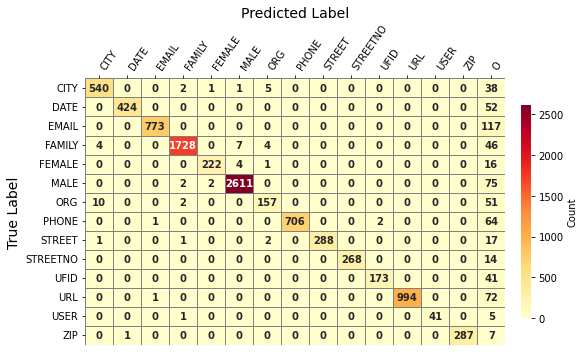

In [19]:
plot_ner_confusion_matrix(aggregated_confusion_matrix_dict_ner)

In [20]:
# files_with_penalty = list()
# for fp, dict_tuple in merged_dict.items():
#     file_d = dict_tuple[0]
#     if "penalty_count" in file_d and file_d["penalty_count"] > 0:
#         files_with_penalty.append(fp)

In [21]:
# len(files_with_penalty)

In [22]:
# fp = files_with_penalty[56]
# fp = 'CodEAlltag_pXL_GERMAN/1-/16-/166201.txt'
# filtered = predicted_text_df[predicted_text_df.FilePath==fp]
# display(pd.DataFrame(ast.literal_eval(filtered.MT5_OriginalTextADF.values[0])))

In [23]:
# print(filtered['PseudonymizedText'].values[0])

In [24]:
# pd.DataFrame(ast.literal_eval(filtered.GELECTRA_PseudonymizedTextADF.values[0]))

In [25]:
# cdp_2022.get_annotation_df_by_file(fp).drop(columns="FilePath")

In [26]:
# print(cdp_2022.read_email(fp)[1])